# Random forest
* Overfitting with n_estimators=100

In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

In [2]:
# Import custom code
from flightdelay.fld import io as flio

# Load data

In [3]:
airlines_df, airports_df, flights_df = flio.load_data()

In [4]:
# Filter data to keys of interest
keys = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT','SCHEDULED_DEPARTURE',
       'DEPARTURE_DELAY', 'SCHEDULED_TIME','DISTANCE']
flights_df = flights_df[keys]

# Remove airports with less than a certain number of flights

In [5]:
all_airports, airport_inverse, airport_count = np.unique(flights_df['ORIGIN_AIRPORT'],return_counts=True,return_inverse=True)

In [6]:
# Determine number of flights for the origin airport
Nflights_orig = np.zeros(len(airport_inverse))
for i in range(len(all_airports)):
    Nflights_orig[np.where(airport_inverse==i)] = airport_count[i]

In [7]:
flights_df = flights_df.loc[flights_df.index[Nflights_orig>=7300]]

# Remove cancelled flights

In [8]:
flights_df = flights_df.dropna()
flights_df.head()

,MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE
0,1,4,AS,ANC,5,-11.0,205.0,1448
1,1,4,AA,LAX,10,-8.0,280.0,2330
2,1,4,US,SFO,20,-2.0,286.0,2296
3,1,4,AA,LAX,20,-5.0,285.0,2342
4,1,4,AS,SEA,25,-1.0,235.0,1448


# Make train and val set

In [9]:
N_flights = 1000000
N_train = int(N_flights*.7)
np.random.seed(0)
flight_take_idx = np.random.permutation(flights_df.index)[:N_flights]
df_trainval = flights_df.loc[flight_take_idx]

In [10]:
df_trainval.head(20)

,MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE
204474,1,3,UA,DEN,955,4.0,117.0,641
2975585,7,1,B6,BOS,1224,-2.0,94.0,399
1961438,5,2,DL,HOU,1500,-3.0,125.0,696
2287055,5,1,EV,ATL,2048,8.0,48.0,145
2422307,6,3,AA,MSY,801,-6.0,104.0,447
1918160,5,6,DL,ATL,2035,-1.0,81.0,366
2956014,7,7,EV,CLE,1015,4.0,104.0,563
2747374,6,1,US,CLT,1430,-1.0,54.0,130
5710770,12,4,WN,MDW,1810,-1.0,70.0,307
3854922,8,4,UA,LAS,1843,-9.0,98.0,414


# Randomly take subset of data

# Compute features
* one-hot day of week
* one-hot month
* one-hot airline
* one-hot airport
* one-hot departure hour

### 0. Original feat

In [11]:
original_feat = {'f_distance':df_trainval['DISTANCE'].values}

In [12]:
y_delay = df_trainval['DEPARTURE_DELAY'].values
y_delay01 = y_delay > 15

### 1. Day of week

In [13]:
def make_onehot_feat_dict(df, feat_key, feat_name):
    # Create features for each day of the week
    feat_vals = df[feat_key].values
    all_vals = np.unique(feat_vals)
    N_vals = len(all_vals)
    N_feat = N_vals - 1

    # Create keys
    keys = [0]*N_feat
    for i in range(N_feat):
        keys[i] = 'f_'+feat_name+'_'+ str(all_vals[i])

    # Create value for each training example in dict
    feat_dict = {}
    for i, k in enumerate(keys):
        this_day = all_vals[i]
        feat_dict[k] = feat_vals == this_day
    return feat_dict

In [14]:
daysfeat_dict = make_onehot_feat_dict(df_trainval, 'DAY_OF_WEEK', 'day')

### 2. Month

In [15]:
monthsfeat_dict = make_onehot_feat_dict(df_trainval, 'MONTH', 'month') 

### 3. Departing airport

In [16]:
dapfeat_dict = make_onehot_feat_dict(df_trainval, 'ORIGIN_AIRPORT', 'dap') 

### 4. Airline

In [17]:
alfeat_dict = make_onehot_feat_dict(df_trainval, 'AIRLINE', 'al') 

### 5. Departure hour

In [19]:
# Add departure hour as a feature
df_trainval['HOUR_DEPARTURE'] = np.floor(df_trainval['SCHEDULED_DEPARTURE'].values/100).astype(int)
hrfeat_dict = make_onehot_feat_dict(df_trainval, 'HOUR_DEPARTURE', 'hr')

# Save new feature matrix

In [20]:
all_dicts = [original_feat, daysfeat_dict, monthsfeat_dict, dapfeat_dict, alfeat_dict, hrfeat_dict]
feat_dict = all_dicts[0].copy()
for d in all_dicts[1:]:
    feat_dict.update(d)

In [21]:
df_feat = pd.DataFrame.from_dict(feat_dict)
df_feat.head()

,f_al_AA,f_al_AS,f_al_B6,f_al_DL,f_al_EV,f_al_F9,f_al_HA,f_al_MQ,f_al_NK,f_al_OO,...,f_month_10,f_month_11,f_month_2,f_month_3,f_month_4,f_month_5,f_month_6,f_month_7,f_month_8,f_month_9
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


# Split data by airport

In [22]:
# zscore all features
from scipy.stats import zscore
df_feat_zscore = df_feat.apply(zscore)

In [23]:
airport_keys = np.array(df_feat.keys()[df_feat.columns.str.startswith('f_dap')])
feat_keys = np.array(df_feat.keys()[~df_feat.columns.str.startswith('f_dap')])
ap_keys = [s[-3:] for s in airport_keys]

N_airports = len(airport_keys)
airport_dfs = {}
airport_y = {}
for k in airport_keys:
    airport_dfs[k[-3:]] = df_feat_zscore[feat_keys][df_feat[k].values]
    airport_y[k[-3:]] = y_delay01[df_feat[k].values]
    
Nflights_by_airport = {}
for k in ap_keys:
    Nflights_by_airport[k] = len(airport_y[k])

# Train model for each airport

In [24]:
# Make train and validation sets
all_X_train = {}
all_X_val = {}
all_y_train = {}
all_y_val = {}
for i, ap in enumerate(ap_keys):
    # Compute number of training examples
    N_train = int(len(airport_dfs[ap])*.7)
    
    # Declare DFs
    all_X_train[ap] = airport_dfs[ap].loc[airport_dfs[ap].index.values[:N_train]].values
    all_X_val[ap] = airport_dfs[ap].loc[airport_dfs[ap].index.values[N_train:]].values

    # Determine labels
    all_y_train[ap] = airport_y[ap][:N_train]
    all_y_val[ap] = airport_y[ap][N_train:]

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
all_models = {}
Ns = 10

for ap in ap_keys:
    print(ap)
    all_models[ap] = RandomForestClassifier(n_estimators=Ns)
    all_models[ap].fit(all_X_train[ap], all_y_train[ap])

ABQ
ALB
ANC
ATL
AUS
BDL
BHM
BNA
BOI
BOS
BTR
BUF
BUR
BWI
CHS
CID
CLE
CLT
CMH
COS
CVG
DAL
DAY
DCA
DEN
DFW
DSM
DTW
ELP
EWR
FAT
FLL
GEG
GRR
GSO
HNL
HOU
HPN
IAD
IAH
ICT
IND
JAN
JAX
JFK
KOA
LAS
LAX
LGA
LGB
LIH
LIT
MAF
MCI
MCO
MDW
MEM
MIA
MKE
MSN
MSP
MSY
OAK
OGG
OKC
OMA
ONT
ORD
ORF
PBI
PDX
PHL
PHX
PIT
PSP
PVD
RDU
RIC
RNO
ROC
RSW
SAN
SAT
SAV
SDF
SEA
SFO
SJC
SJU
SLC
SMF
SNA
STL
TPA
TUL
TUS
TYS


# Evaluate model

In [41]:
# Prepare true and predicted scores
ally_true = np.zeros(0)
ally_pred = np.zeros(0)
ally_predp = np.zeros(0)
for ap in all_models.keys():
    ally_true = np.append(ally_true,all_y_train[ap])
    ally_pred = np.append(ally_pred, all_models[ap].predict(all_X_train[ap]))
    ally_predp = np.append(ally_predp, all_models[ap].predict_proba(all_X_train[ap])[:,1])
    
ally_trueV = np.zeros(0)
ally_predV = np.zeros(0)
ally_predpV = np.zeros(0)
for ap in all_models.keys():
    ally_trueV = np.append(ally_trueV,all_y_val[ap])
    ally_predV = np.append(ally_predV, all_models[ap].predict(all_X_val[ap]))
    ally_predpV = np.append(ally_predpV, all_models[ap].predict_proba(all_X_val[ap])[:,1])

In [42]:
print('accuracy: ',1-sum(np.abs(ally_pred-ally_true))/len(ally_pred))

accuracy:  0.891319718778


In [43]:
ap_modelres = {}
ap_modelres['confuse'] = {}
ap_modelres['accuracy'] = {}
all_confuse = np.zeros((2,2))
for ap in all_models.keys():
    ap_modelres['confuse'][ap] = confusion_matrix(all_y_train[ap], all_models[ap].predict(all_X_train[ap]))
    ap_modelres['accuracy'][ap] = all_models[ap].score(all_X_train[ap], all_y_train[ap])
    all_confuse += np.array(ap_modelres['confuse'][ap])
    
print('Train True positive rate:', all_confuse[1,1]/sum(all_confuse[1]))
print('Train True negative rate:', all_confuse[0,0]/sum(all_confuse[0]))
print('Train Accuracy: ', (all_confuse[0,0]+all_confuse[1,1])/np.sum(all_confuse))
print(all_confuse)

Train True positive rate: 0.513031462923
Train True negative rate: 0.974492699978
Train Accuracy:  0.891319718778
[[ 558129.   14609.]
 [  61322.   64604.]]


In [44]:
ap_modelres = {}
ap_modelres['confuse'] = {}
ap_modelres['accuracy'] = {}
all_confuse = np.zeros((2,2))
for ap in all_models.keys():
    ap_modelres['confuse'][ap] = confusion_matrix(all_y_val[ap], all_models[ap].predict(all_X_val[ap]))
    ap_modelres['accuracy'][ap] = all_models[ap].score(all_X_val[ap], all_y_val[ap])
    all_confuse += np.array(ap_modelres['confuse'][ap])
    
print('Val True positive rate:', all_confuse[1,1]/sum(all_confuse[1]))
print('Val True negative rate:', all_confuse[0,0]/sum(all_confuse[0]))
print('Val Accuracy: ', (all_confuse[0,0]+all_confuse[1,1])/np.sum(all_confuse))
print(all_confuse)

Val True positive rate: 0.134100460643
Val True negative rate: 0.925522144988
Val Accuracy:  0.781530478684
[[ 226752.   18247.]
 [  47182.    7307.]]


0.917012623243
0.568630344982


(0, 1)

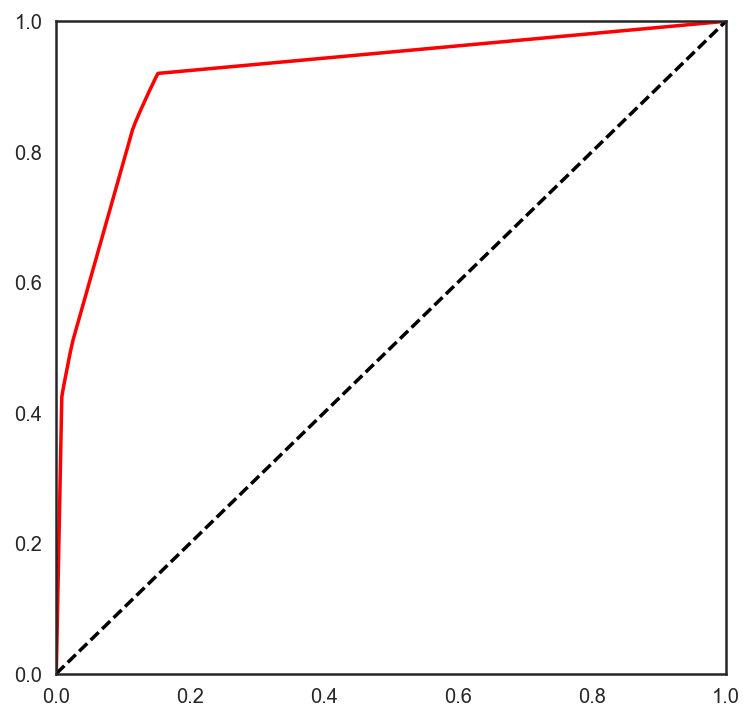

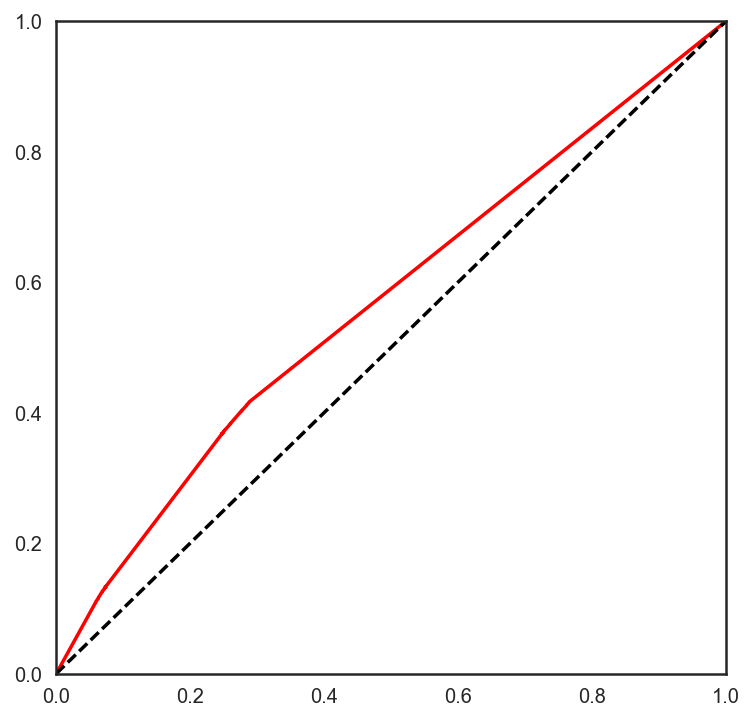

In [45]:
fpr, tpr, th = roc_curve(ally_true, ally_predp)
print(roc_auc_score(ally_true, ally_predp))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

fpr, tpr, th = roc_curve(ally_trueV, ally_predpV)
print(roc_auc_score(ally_trueV, ally_predpV))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))